Load dataset

In [ ]:
# !pip install pyprojroot


d:\GitHub\Blood-Donors\data


In [ ]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
from pyprojroot import here

df = pd.read_csv(here("data/recent_donations.csv"))
df

,unique_number,class_year,birth_year,first_donation_year,gender,y_2009,y_2010,y_2011,y_2012,y_2013,y_2014,y_2015,y_2016,y_2018,y_2019,y_2017,y_2020,y_2021,y_2022,y_2023
0,26308560,"(1960,1970]",1965,1985,M,0,0,0,0,0,0,0,0,0,0,0,1,1,3,1
1,26309283,"(1960,1970]",1966,2002,M,2,1,2,2,1,1,3,3,4,1,3,3,3,3,4
2,26317365,"(1960,1970]",1961,1984,M,4,2,3,3,3,4,3,3,2,3,3,2,0,1,0
3,26318451,"(1960,1970]",1967,1989,M,0,3,3,4,4,4,2,3,3,1,2,3,1,0,0
4,26319465,"(1960,1970]",1964,1994,F,1,2,2,1,2,1,1,0,0,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,27220599,"(1970,1980]",1980,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9232,27220806,"(2000,2010]",2002,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3
9233,27221247,"(1990,2000]",2000,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9234,27221274,"(1960,1970]",1966,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3


In [15]:
df["gender"] = df["gender"].map({"M": 0, "F": 1})

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[["birth_year", "first_donation_year"]] = scaler.fit_transform(df[["birth_year", "first_donation_year"]])

year_cols = sorted([col for col in df.columns if col.startswith("y_")])
donation_data = df[year_cols].values  # matrice [n_donatori, T]

features = df[["gender", "birth_year", "first_donation_year"]].values  # shape: [n_donatori, n_features]


Let's start with a simple Hidden Markov Model. In this case we assume that the emmissions are continuous and not discrete

In [58]:
from hmmlearn import hmm

# Estrai le colonne delle osservazioni
y_cols = [col for col in df.columns if col.startswith("y_")]
sequences = df[y_cols].to_numpy()

# Prepara i dati per hmmlearn
X = sequences.reshape(-1, 1)  # hmmlearn richiede forma (n_samples, n_features)
lengths = [len(y_cols)] * sequences.shape[0]  # una sequenza per ogni individuo

# Costruisci l'HMM (es: GaussianHMM, Poisson non è supportato direttamente)
model = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=100, random_state=42)
model.fit(X, lengths)


GaussianHMM(n_components=3, n_iter=100, random_state=42)

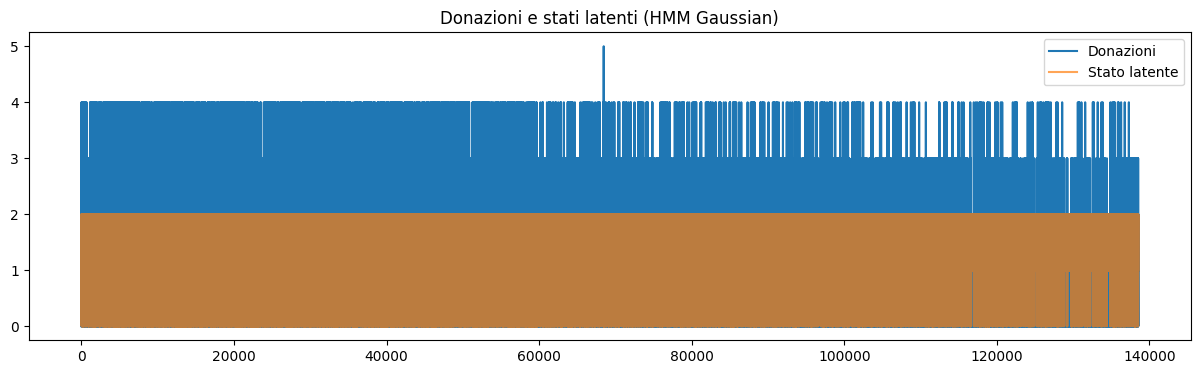

In [59]:
states = model.predict(X)  # X = osservazioni (n_donors * T, 1)

plt.figure(figsize=(15, 4))
plt.plot(X, label="Donazioni")
plt.plot(states, label="Stato latente", alpha=0.7)
plt.legend()
plt.title("Donazioni e stati latenti (HMM Gaussian)")
plt.show()


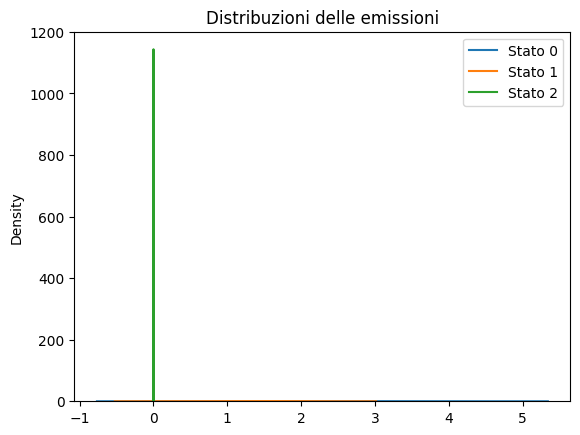

In [60]:
import seaborn as sns

for i in range(model.n_components):
    mu = model.means_[i][0]
    sigma = np.sqrt(model.covars_[i][0])
    sns.kdeplot(np.random.normal(mu, sigma, 1000), label=f"Stato {i}")

plt.title("Distribuzioni delle emissioni")
plt.legend()
plt.show()


## Pyro

In [50]:
# Estrai la matrice y: righe = individui, colonne = anni
donation_cols = [col for col in df.columns if col.startswith("y_")]
Y = df[donation_cols].fillna(0).astype(int).to_numpy()  # [n_donors, T]
Y_tensor = torch.tensor(Y, dtype=torch.float32)  # Pyro lavora con torch

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroParam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam
from torch.distributions import constraints
from pyro import poutine
import torch

class SimpleDiscreteHMM:
    def __init__(self, num_states=3):
        self.num_states = num_states
        self.lambdas = PyroParam(torch.ones(num_states), constraint=constraints.positive)
        self.start_probs = PyroParam(torch.ones(num_states) / num_states, constraint=constraints.simplex)
        self.trans_probs = PyroParam(torch.ones(num_states, num_states) / num_states, constraint=constraints.simplex)

    @config_enumerate
    def model(self, Y):
        n_donors, T = Y.shape
        num_states = self.num_states

        with pyro.plate("donors", n_donors, dim=-2):
            z_prev = pyro.sample("z_0", dist.Categorical(pyro.param("start_probs")))

            for t in range(T):
                z_t = pyro.sample(f"z_{t}", dist.Categorical(pyro.param("trans_probs")[z_prev]))
                pyro.sample(f"y_{t}", dist.Poisson(self.lambdas[z_t]), obs=Y[:, t])
                z_prev = z_t

from pyro.nn import PyroModule

class Guide(PyroModule):
    def __init__(self, num_states):
        super().__init__()
        self.num_states = num_states

    @config_enumerate
    def forward(self, Y):
        pass  # nessun parametro latente globale da approssimare qui



In [62]:
model = SimpleDiscreteHMM(num_states=3)
guide = Guide(num_states=3)

optimizer = Adam({"lr": 0.01})
svi = SVI(model.model, guide, optimizer, loss=TraceEnum_ELBO())

for step in range(500):
    loss = svi.step(Y_tensor)
    if step % 50 == 0:
        print(f"Step {step}: loss = {loss:.2f}")



KeyError: 'start_probs'

In [63]:
print("Lambda per stato:", model.lambdas.detach().numpy())
print("Probabilità iniziali:", model.start_probs.detach().numpy())
print("Matrice di transizione:", model.trans_probs.detach().numpy())


AttributeError: 'PyroParam' object has no attribute 'detach'